In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import json
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [14]:
# Load the dataset
file_path = "GlobalElectricityStatistics.csv"
electricity_data = pd.read_csv(file_path)

# Display the first and last five rows of the DataFrame
print("First five rows:")
print(electricity_data.head())

print("\nLast five rows:")
print(electricity_data.tail())

# Show basic information about the DataFrame
print("\nBasic dataset information:")
print(f"Dataset dimensions: {electricity_data.shape}")
print("\nColumn details:")
print(electricity_data.info())

print("\nData types and memory usage:")
print(electricity_data.info(memory_usage='deep'))

print("\nStatistical summary of the data:")
print(electricity_data.describe())

# Check for missing values
print("\nMissing values check:")
missing_values = electricity_data.isnull().sum()
print(f"Number of missing values per column:\n{missing_values}")
print(f"Total number of missing values: {electricity_data.isnull().sum().sum()}")
print(f"Percentage of missing values: {(electricity_data.isnull().sum().sum() / (electricity_data.shape[0] * electricity_data.shape[1])) * 100:.2f}%")

# Handle missing values
# 1. Fill numeric missing data with 0 (assuming missing means no data or zero)
electricity_data_cleaned = electricity_data.fillna(0)

# 2. Check if any missing values remain
print("\nMissing values check after handling:")
print(f"Total remaining missing values: {electricity_data_cleaned.isnull().sum().sum()}")

# 3. Check for inconsistencies in the data - e.g., non-numeric values in numeric columns
# Assume all columns from the fourth onward represent yearly data
numeric_columns = electricity_data.columns[3:]
non_numeric_data = electricity_data[numeric_columns].applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x)) and not pd.isna(x))
non_numeric_count = non_numeric_data.sum().sum()

print("\nNon-numeric data detection:")
print(f"Number of non-numeric entries in numeric columns: {non_numeric_count}")

if non_numeric_count > 0:
    # Show sample locations of non-numeric values
    print("Sample positions of non-numeric data:")
    for col in numeric_columns:
        non_numeric_in_col = electricity_data[non_numeric_data[col]][col]
        if len(non_numeric_in_col) > 0:
            print(f"Non-numeric values in column '{col}': {non_numeric_in_col.iloc[0:5].tolist() if len(non_numeric_in_col) > 5 else non_numeric_in_col.tolist()}")

    # Convert non-numeric values to NaN and fill them with 0
    for col in numeric_columns:
        electricity_data_cleaned[col] = pd.to_numeric(electricity_data[col], errors='coerce').fillna(0)

print("\nFirst five rows of cleaned data:")
print(electricity_data_cleaned.head())

# Save the cleaned data
electricity_data_cleaned.to_csv("GlobalElectricityStatistics_cleaned.csv", index=False)
print("\nCleaned data has been saved as 'GlobalElectricityStatistics_cleaned.csv'")

First five rows:
          Country              Features          Region     1980     1981  \
0     Afghanistan  distribution losses   Asia & Oceania  0.06594  0.06944   
1         Albania  distribution losses           Europe  0.16100  0.16100   
2         Algeria  distribution losses           Africa  0.77700  0.95400   
3  American Samoa  distribution losses   Asia & Oceania  0.00490  0.00469   
4          Angola  distribution losses           Africa  0.16900  0.16900   

      1982     1983     1984     1985     1986  ...     2012      2013  \
0  0.06664  0.07000  0.07133  0.07238  0.07945  ...   0.4040   0.49000   
1  0.16100  0.16000  0.16000  0.16100  0.16200  ...   1.1193   1.95349   
2  1.06500  1.39000  1.64900  1.84600  1.85400  ...  11.0680  11.02300   
3  0.00469  0.00497  0.00483  0.00581  0.00525  ...   0.0000   0.00000   
4  0.18000  0.19600  0.16800  0.20200  0.20200  ...   0.6990   0.92600   

       2014    2015     2016       2017      2018      2019      2020  \
0 

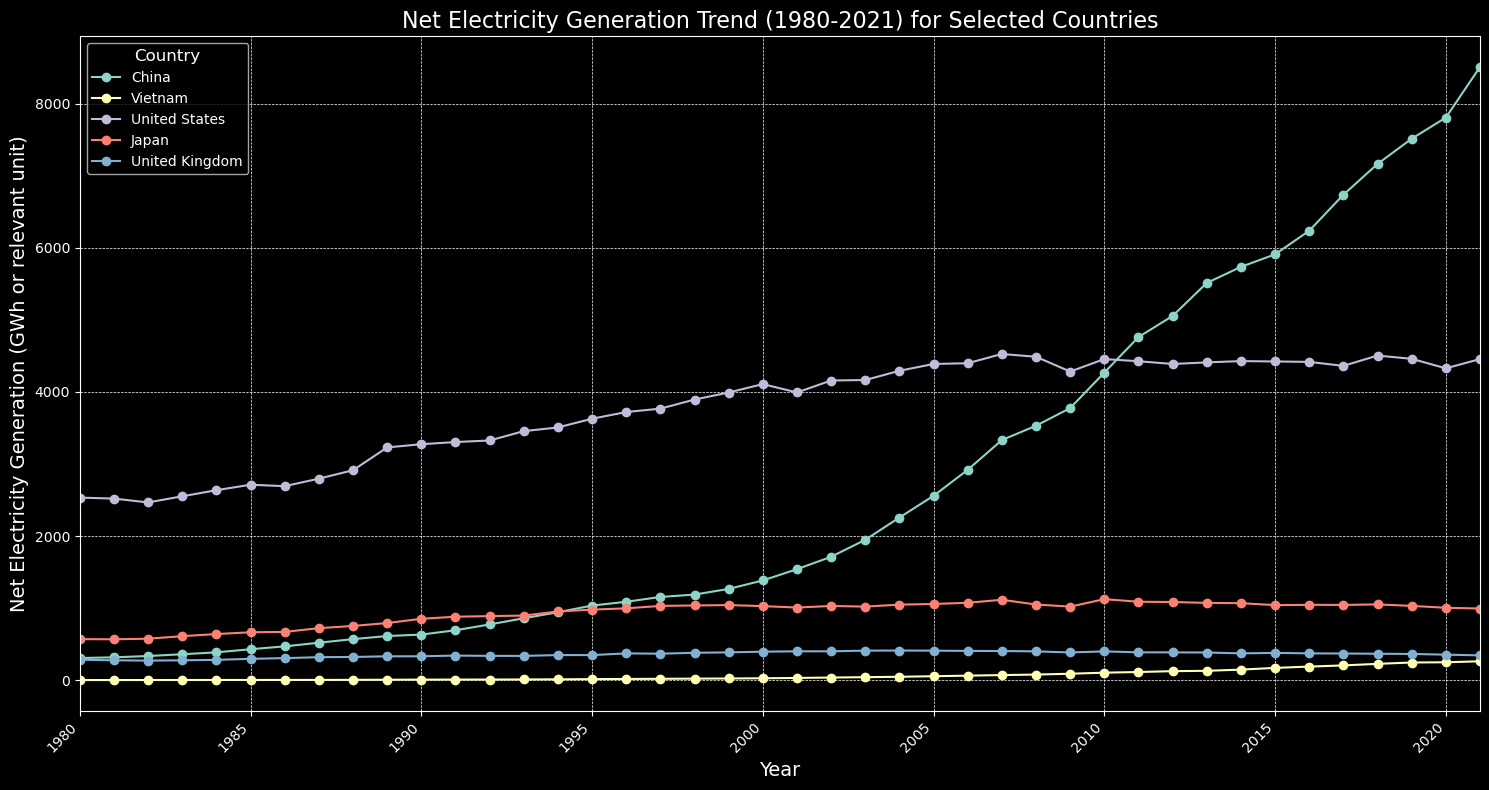

In [15]:

selected_countries = ['China', 'Vietnam', 'United States', 'Japan', 'United Kingdom']
electricity_viz_data = electricity_data_cleaned[electricity_data_cleaned['Country'].isin(selected_countries)]


year_columns_to_check = [col for col in electricity_viz_data.columns if col.isdigit() or (isinstance(col, str) and col.isnumeric())]


years_to_plot_str = [str(year) for year in range(1980, 2022)]
years_present = [col for col in years_to_plot_str if col in electricity_viz_data.columns]


aggregated_data = electricity_viz_data.groupby('Country')[years_present].sum()


plot_data = aggregated_data.T
plot_data.index = plot_data.index.astype(int)  # Convert year index to int for correct sorting


plt.figure(figsize=(15, 8))

for country in selected_countries:
    if country in plot_data.columns:
        plt.plot(plot_data.index, plot_data[country], label=country, marker='o', linestyle='-')

# Add title and labels
plt.title('Net Electricity Generation Trend (1980-2021) for Selected Countries', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Generation (GWh or relevant unit)', fontsize=14)
plt.legend(title='Country', fontsize=10, title_fontsize='12')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.xlim(1980, 2021) 
plt.tight_layout()
plt.show()

Duplicate country entries detected. Aggregating data by country...

Average Annual Electricity Generation (2000–2021) by Country:
                   Country  Average Generation (2000-2021)
40                   China                     4553.179078
219          United States                     4357.464005
98                   India                     1262.613957
169                 Russia                     1101.134016
106                  Japan                     1052.471425
..                     ...                             ...
71       Former Yugoslavia                        0.000000
70         Former U.S.S.R.                        0.000000
133             Micronesia                        0.000000
68   Former Czechoslovakia                        0.000000
93     Hawaiian Trade Zone                        0.000000

[230 rows x 2 columns]

Country with the Highest Average Generation (2000–2021):
Country                                 China
Average Generation (2000-2021)    

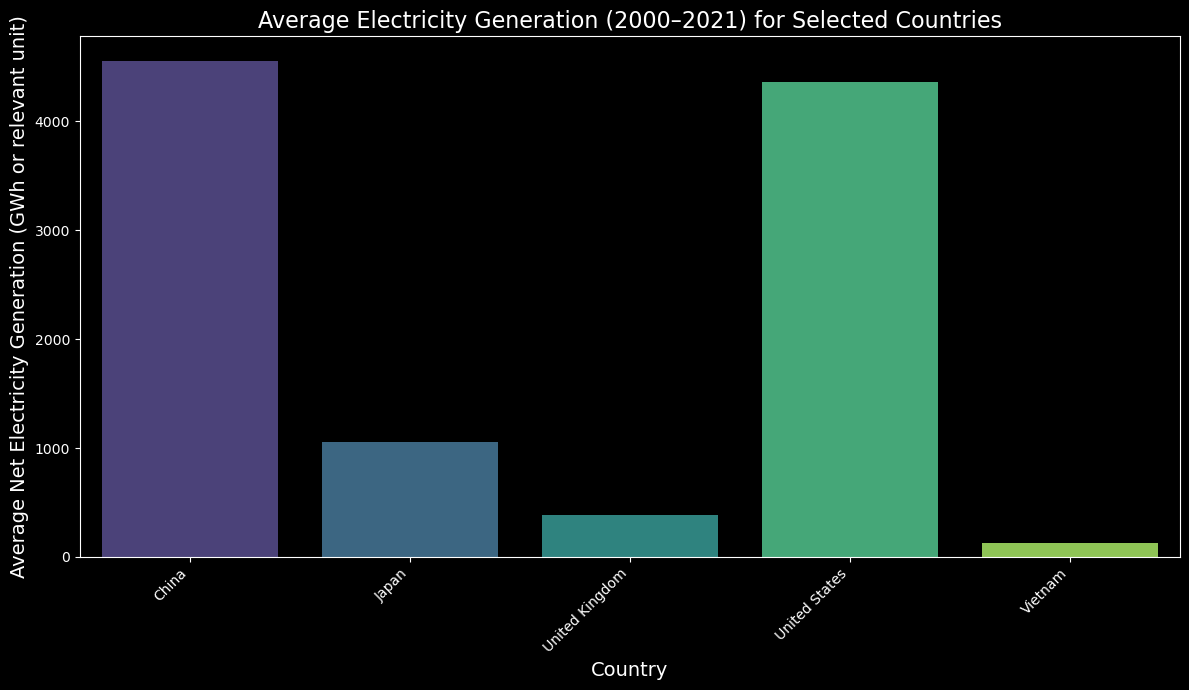

In [16]:
# 1.3 Data Aggregation and Summary

years_for_avg_str = [str(year) for year in range(2000, 2022)]

years_present_for_avg = [
    col for col in years_for_avg_str 
    if col in electricity_data_cleaned.columns and pd.api.types.is_numeric_dtype(electricity_data_cleaned[col])
]

if not years_present_for_avg:
    print("Error: No numeric year data found for 2000–2021 in the dataset.")
else:
    avg_electricity_data = electricity_data_cleaned[['Country'] + years_present_for_avg].copy()  # Use .copy() to avoid SettingWithCopyWarning

    # Clean step
    if avg_electricity_data['Country'].duplicated().any():
        print("Duplicate country entries detected. Aggregating data by country...")
        # Sum numeric columns per country
        numeric_cols_to_sum = [col for col in years_present_for_avg if pd.api.types.is_numeric_dtype(avg_electricity_data[col])]
        if not numeric_cols_to_sum:
            print("Warning: No numeric year columns found for aggregation.")
        avg_electricity_data = avg_electricity_data.groupby('Country', as_index=False)[numeric_cols_to_sum].sum()

    # Compute
    avg_electricity_data['Average Generation (2000-2021)'] = avg_electricity_data[years_present_for_avg].mean(axis=1)

    # Display average
    print("\nAverage Annual Electricity Generation (2000–2021) by Country:")
    avg_generation_sorted = avg_electricity_data[['Country', 'Average Generation (2000-2021)']].sort_values(
        by='Average Generation (2000-2021)', ascending=False)
    print(avg_generation_sorted)

    # b. Identify and display the countries with the highest and lowest average generation
    highest_avg_country = avg_electricity_data.loc[avg_electricity_data['Average Generation (2000-2021)'].idxmax()]

    # Filter non-zero data
    non_zero_avg_data = avg_electricity_data[avg_electricity_data['Average Generation (2000-2021)'] > 0]
    if not non_zero_avg_data.empty:
        lowest_avg_country = non_zero_avg_data.loc[non_zero_avg_data['Average Generation (2000-2021)'].idxmin()]
    else:
        lowest_avg_country = pd.Series({
            'Country': "N/A (All countries have zero or missing average generation)",
            'Average Generation (2000-2021)': 0.0
        })

    print("\nCountry with the Highest Average Generation (2000–2021):")
    print(highest_avg_country[['Country', 'Average Generation (2000-2021)']])
    print("\nCountry with the Lowest Non-Zero Average Generation (2000–2021):")
    print(lowest_avg_country[['Country', 'Average Generation (2000-2021)']])

    # c. Visualize the average generation comparison for selected countries
    avg_selected_countries_data = avg_electricity_data[avg_electricity_data['Country'].isin(selected_countries)]

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Country', y='Average Generation (2000-2021)', data=avg_selected_countries_data,
                palette='viridis', hue='Country', legend=False)
    plt.title('Average Electricity Generation (2000–2021) for Selected Countries', fontsize=16)
    plt.xlabel('Country', fontsize=14)
    plt.ylabel('Average Net Electricity Generation (GWh or relevant unit)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Columns in the original dataset: ['Country', 'Features', 'Region', '1980', '1981', '1982', '1983', '1984', '1985', '1986'] ...
Unique values in the 'Features' column of the original dataset:
['distribution losses ' 'exports ' 'imports ' 'net generation']
Number of net generation records: 230
Number of import records: 230
Number of export records: 230
Number of distribution loss records: 230

Total number of countries/regions: 230

First few rows of annual net consumption data by country:
          Country     1980     1981     1982     1983     1984
0     Afghanistan  0.87606  0.92256  0.88536  0.93000  0.94767
1         Albania  2.97400  2.98700  2.98100  2.97500  2.97700
2         Algeria  5.91500  6.71300  7.73300  8.20700  8.95900
3  American Samoa  0.06510  0.06231  0.06231  0.06603  0.06417
4          Angola  0.73600  0.73700  0.81500  0.83200  0.86000

Top 10 countries by average net electricity consumption:
             Country  Average Net Consumption
219    United States     

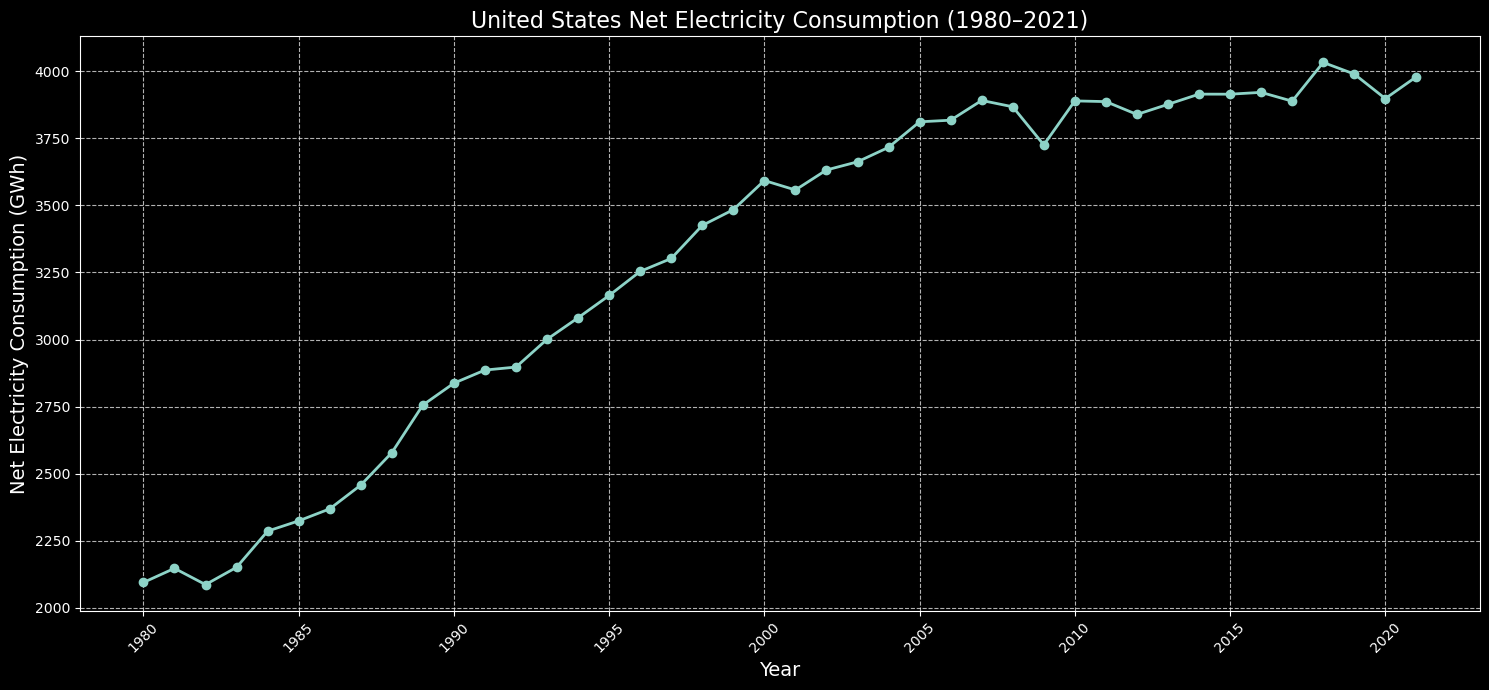


Head of time series data:
   Year  Net Consumption
0  1980      2094.449000
1  1981      2147.102862
2  1982      2086.441352
3  1983      2150.954584
4  1984      2285.796394
    Year  Net Consumption
37  2017      3888.305646
38  2018      4032.628268
39  2019      3989.378249
40  2020      3897.894198
41  2021      3979.279761


In [17]:
# Task 2: Prediction Modeling and Discussion

# 2.1 Data Preparation for Prediction

# Read
original_data = pd.read_csv("GlobalElectricityStatistics.csv")
print("Columns in the original dataset:", original_data.columns[:10].tolist(), "...")

# Check unique
print("Unique values in the 'Features' column of the original dataset:")
print(original_data['Features'].unique())

# Filter
net_generation_data = original_data[original_data['Features'].str.strip().str.lower() == 'net generation'].copy()
imports_data = original_data[original_data['Features'].str.strip().str.lower() == 'imports'].copy()
exports_data = original_data[original_data['Features'].str.strip().str.lower() == 'exports'].copy()
distribution_losses_data = original_data[original_data['Features'].str.strip().str.lower() == 'distribution losses'].copy()

print(f"Number of net generation records: {len(net_generation_data)}")
print(f"Number of import records: {len(imports_data)}")
print(f"Number of export records: {len(exports_data)}")
print(f"Number of distribution loss records: {len(distribution_losses_data)}")

# a. Calculate net consumption values for each country from 1980 to 2021

year_columns = [str(year) for year in range(1980, 2022)]

all_countries = pd.unique(original_data['Country'])
print(f"\nTotal number of countries/regions: {len(all_countries)}")

net_consumption_df = pd.DataFrame(index=all_countries)

def get_value_for_country_year(df, country, year):
    try:
        value = df[df['Country'] == country][year].values
        return float(value[0]) if len(value) > 0 else 0
    except Exception:
        return 0

for year in year_columns:
    year_consumption = []
    
    for country in all_countries:
        net_gen = get_value_for_country_year(net_generation_data, country, year)
        imports = get_value_for_country_year(imports_data, country, year)
        exports = get_value_for_country_year(exports_data, country, year)
        losses = get_value_for_country_year(distribution_losses_data, country, year)
        
        # Compute
        net_consumption = net_gen + imports - exports - losses
        year_consumption.append(net_consumption)
    
    net_consumption_df[year] = year_consumption

net_consumption_df.reset_index(inplace=True)
net_consumption_df.rename(columns={'index': 'Country'}, inplace=True)

# Display 
print("\nFirst few rows of annual net consumption data by country:")
print(net_consumption_df[['Country'] + year_columns[:5]].head())

# b. Select the country with the highest average net consumption

# Compute
net_consumption_df['Average Net Consumption'] = net_consumption_df[year_columns].mean(axis=1)

# Sort 
top_countries = net_consumption_df.sort_values('Average Net Consumption', ascending=False).head(10)
print("\nTop 10 countries by average net electricity consumption:")
print(top_countries[['Country', 'Average Net Consumption']])

# Get
top_country = top_countries.iloc[0]['Country']
top_country_avg = top_countries.iloc[0]['Average Net Consumption']
print(f"\nThe country with the highest average net consumption is: {top_country}")
print(f"Average net consumption: {top_country_avg:.2f} GWh")

# Plot
plt.figure(figsize=(15, 7))
top_country_data = net_consumption_df[net_consumption_df['Country'] == top_country]
years = [int(year) for year in year_columns]
values = [top_country_data[year].values[0] for year in year_columns]

plt.plot(years, values, marker='o', linewidth=2)
plt.title(f'{top_country} Net Electricity Consumption (1980–2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years[::5], rotation=45)  # Show every 5 years
plt.tight_layout()
plt.show()

# c. Split net consumption data into training and testing sets for the selected country
from sklearn.model_selection import train_test_split

# Prepare time series data
time_series_data = pd.DataFrame({
    'Year': years,
    'Net Consumption': values
})

actual_consumption = pd.DataFrame({
    'Year': [2022, 2023, 2024],
    'Actual Net Consumption (GWh)': [4128.2, 4084.6, 4086.0]  # Actual data from energy databases
})

print("\nHead of time series data:")
print(time_series_data.head())
print(time_series_data.tail())

In [18]:
RUN_OPTUNA_OPTIMIZATION = False

In [19]:
# Flexible MLP Model definition with variable layers and neuron counts
class FlexibleMLPModel(nn.Module):
    def __init__(
        self,
        input_dim=1,
        hidden_layers=None,
        output_dim=1,
        dropout_rate=0.2,
        activation_func=nn.ReLU,
    ):
        super(FlexibleMLPModel, self).__init__()

        if hidden_layers is None:
            hidden_layers = [64, 32]

        # First layer - input to first hidden layer
        layers = [nn.Linear(input_dim, hidden_layers[0])]

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            layers.append(activation_func())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))

        # Output layer
        layers.append(activation_func())
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        self.model = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(1)  # Add feature dimension

        return self.model(x)


# Model evaluation function: calculate MSE and R²
def evaluate_model(model, X_test, y_test, scaler_y=None):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        
        if scaler_y:
            # If scaler is provided, inverse transform for real-world metrics
            y_test_original = scaler_y.inverse_transform(y_test.cpu().numpy())
            y_pred_original = scaler_y.inverse_transform(y_pred.cpu().numpy())
            mse = mean_squared_error(y_test_original, y_pred_original)
            r2 = r2_score(y_test_original, y_pred_original)
        else:
            r2 = r2_score(y_test.cpu().numpy(), y_pred.cpu().numpy())

    return mse, r2


# Train model with early stopping
def train_model_with_early_stopping(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer,
    criterion,
    patience=30,
    max_epochs=500,
    verbose=False,
):
    best_val_loss = float("inf")
    no_improve_epochs = 0
    best_model_state = None

    for epoch in range(max_epochs):
        # Training mode
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # Evaluation mode
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch + 1}")
            model.load_state_dict(best_model_state)
            break

        if verbose and epoch % 50 == 0:
            print(
                f"Epoch {epoch + 1}/{max_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}"
            )

    if best_model_state:
        model.load_state_dict(best_model_state)

    return best_val_loss

print("✅ FlexibleMLPModel and helper functions defined and ready for use.")

✅ FlexibleMLPModel and helper functions defined and ready for use.


Prepare For Hyperparameter Optimization - Improving MLP Model Performance
Train set size: torch.Size([29, 1]), torch.Size([29, 1])
Validation set size: torch.Size([6, 1]), torch.Size([6, 1])
Test set size: torch.Size([7, 1]), torch.Size([7, 1])
Train set size: torch.Size([29, 1]), torch.Size([29, 1])
Validation set size: torch.Size([6, 1]), torch.Size([6, 1])
Test set size: torch.Size([7, 1]), torch.Size([7, 1])


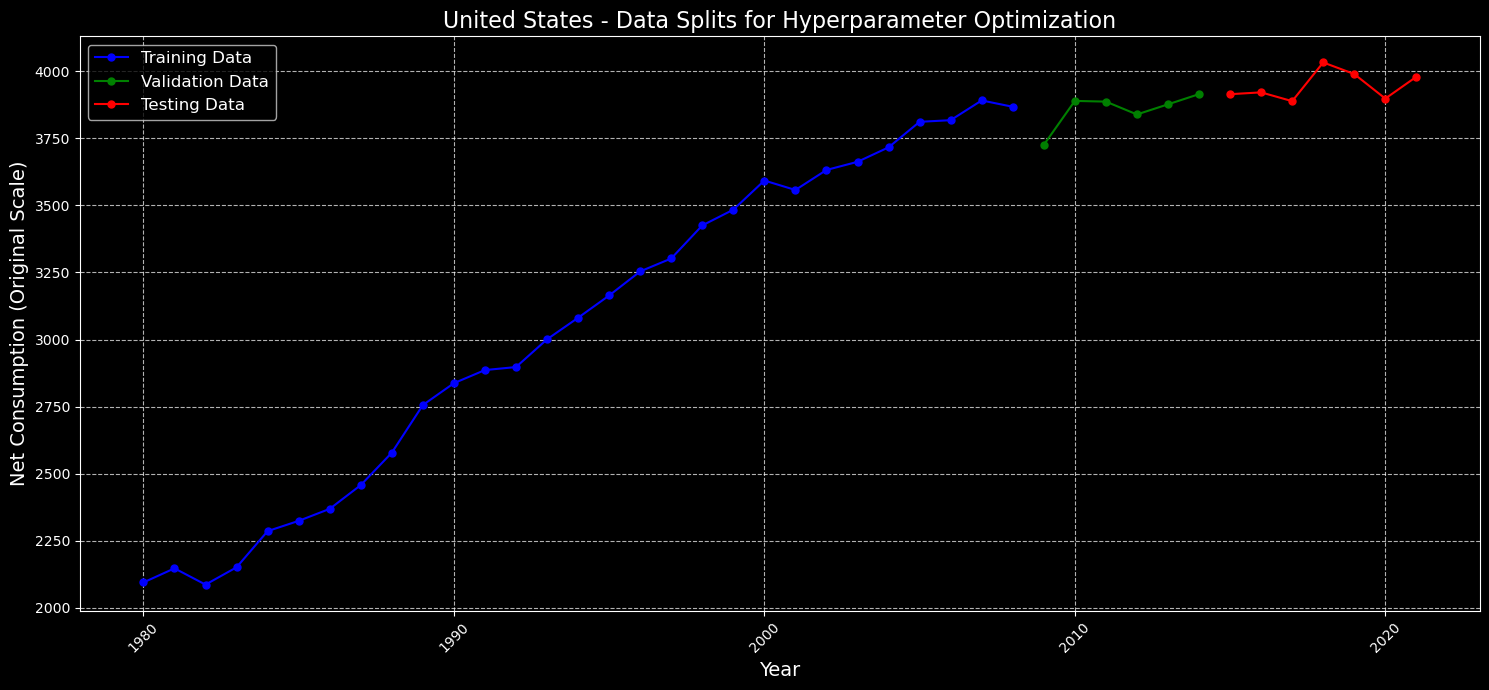

In [20]:
# Data preparation: split into train, validation, and test sets
print("Prepare For Hyperparameter Optimization - Improving MLP Model Performance")

# Ensure data is sorted
ordered_data = time_series_data.sort_values(by="Year")
X_ordered = ordered_data[["Year"]].values
y_ordered = ordered_data["Net Consumption"].values

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler() 
X_scaled = scaler_X.fit_transform(X_ordered.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y_ordered.reshape(-1, 1))

# Split into train (70%), val (15%), test (15%)
train_size = int(len(X_scaled) * 0.7)
val_size = int(len(X_scaled) * 0.15)
test_size = len(X_scaled) - train_size - val_size

X_train_hpo = X_scaled[:train_size]
X_val_hpo = X_scaled[train_size : train_size + val_size]
X_test_hpo = X_scaled[train_size + val_size :]

y_train_hpo = y_scaled[:train_size]
y_val_hpo = y_scaled[train_size : train_size + val_size]
y_test_hpo = y_scaled[train_size + val_size :]

# Convert to PyTorch tensors
device = torch.device("cpu")
X_train_tensor_hpo = torch.FloatTensor(X_train_hpo).to(device)
y_train_tensor_hpo = torch.FloatTensor(y_train_hpo).to(device)
X_val_tensor_hpo = torch.FloatTensor(X_val_hpo).to(device)
y_val_tensor_hpo = torch.FloatTensor(y_val_hpo).to(device)
X_test_tensor_hpo = torch.FloatTensor(X_test_hpo).to(device)
y_test_tensor_hpo = torch.FloatTensor(y_test_hpo).to(device)

print(f"Train set size: {X_train_tensor_hpo.shape}, {y_train_tensor_hpo.shape}")
print(f"Validation set size: {X_val_tensor_hpo.shape}, {y_val_tensor_hpo.shape}")
print(f"Test set size: {X_test_tensor_hpo.shape}, {y_test_tensor_hpo.shape}")

# Activation function mapping
activation_functions_map = {
    "ReLU": nn.ReLU,
    "LeakyReLU": lambda: nn.LeakyReLU(0.1),
    "ELU": nn.ELU,
    "GELU": nn.GELU,
}

# Plotting the data splits
plt.figure(figsize=(15, 7))

# Original data (unscaled, for x-axis use original years)
# X_ordered contains the original years, y_ordered contains the original net consumption
original_years = X_ordered.flatten() # Flatten if it's a column vector

# Plot training data
plt.plot(original_years[:train_size], y_ordered[:train_size], 'bo-', label='Training Data', markersize=5)

# Plot validation data
plt.plot(original_years[train_size : train_size + val_size], y_ordered[train_size : train_size + val_size], 'go-', label='Validation Data', markersize=5)

# Plot testing data
plt.plot(original_years[train_size + val_size :], y_ordered[train_size + val_size :], 'ro-', label='Testing Data', markersize=5)

plt.title(f'{top_country} - Data Splits for Hyperparameter Optimization', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Consumption (Original Scale)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# This cell loads best hyperparameters from best_params.json and rebuilds/trains the model in English.

final_best_model = None
final_best_params = None
final_best_scores = (float('nan'), float('nan')) # (mse, r2)
optuna_study = None

if RUN_OPTUNA_OPTIMIZATION:
    print("🚀 Running Optuna hyperparameter optimization...")
    n_trials_optuna = 50000
    final_best_model, final_best_params, final_best_scores, optuna_study = run_hyperparameter_optimization(
        X_train_tensor_hpo, y_train_tensor_hpo,
        X_val_tensor_hpo, y_val_tensor_hpo,
        X_test_tensor_hpo, y_test_tensor_hpo,
        scaler_y=scaler_y,
        device=device,
        n_trials=n_trials_optuna,
        study_name="mlp_electricity_forecasting_conditional"
    )
    print("✅ Optuna optimization completed.")

else:
    print("💡 Loading saved best hyperparameters and rebuilding/training model...")
    params_filepath = "best_params.json"
    try:
        with open(params_filepath, "r") as f:
            loaded_params = json.load(f)
        print(f"Successfully loaded hyperparameters from {params_filepath}.")
        final_best_params = loaded_params

        input_dim_hpo = X_train_tensor_hpo.shape[1]
        output_dim_hpo = y_train_tensor_hpo.shape[1] if len(y_train_tensor_hpo.shape) > 1 else 1

        n_layers = loaded_params["n_layers"]
        hidden_layers_conf = [loaded_params[f"n_units_l{i}"] for i in range(n_layers)]

        activation_name = loaded_params["activation"]
        activation_func_loaded = activation_functions_map[activation_name]

        reconstructed_model = FlexibleMLPModel(
            input_dim=input_dim_hpo,
            hidden_layers=hidden_layers_conf,
            output_dim=output_dim_hpo,
            dropout_rate=loaded_params["dropout_rate"],
            activation_func=activation_func_loaded,
        ).to(device)
        print("Model rebuilt according to loaded hyperparameters.")

        print("Training rebuilt model on combined train+val set with loaded best parameters...")

        optimizer_name_loaded = loaded_params["optimizer"]
        lr_loaded = loaded_params["learning_rate"]
        wd_loaded = loaded_params["weight_decay"]

        if optimizer_name_loaded == "Adam":
            optimizer_loaded = optim.Adam(reconstructed_model.parameters(), lr=lr_loaded, weight_decay=wd_loaded)
        elif optimizer_name_loaded == "RMSprop":
            optimizer_loaded = optim.RMSprop(reconstructed_model.parameters(), lr=lr_loaded, weight_decay=wd_loaded)
        else: # SGD
            optimizer_loaded = optim.SGD(reconstructed_model.parameters(), lr=lr_loaded, weight_decay=wd_loaded, momentum=0.9)

        criterion_loaded = nn.MSELoss()
        X_full_train_hpo = torch.cat([X_train_tensor_hpo, X_val_tensor_hpo], dim=0)
        y_full_train_hpo = torch.cat([y_train_tensor_hpo, y_val_tensor_hpo], dim=0)

        reconstructed_model.train()
        max_epochs_final_train = 50000

        for epoch in range(max_epochs_final_train):
            optimizer_loaded.zero_grad()
            y_pred_rt = reconstructed_model(X_full_train_hpo)
            loss_rt = criterion_loaded(y_pred_rt, y_full_train_hpo)
            loss_rt.backward()
            optimizer_loaded.step()
            if (epoch + 1) % 100 == 0:
                print(f"Training rebuilt model - Epoch {epoch + 1}/{max_epochs_final_train}, Loss: {loss_rt.item():.6f}")

        final_best_model = reconstructed_model
        print("✅ Rebuilt model training completed.")

        print("Evaluating loaded and trained model...")
        mse_loaded, r2_loaded = evaluate_model(final_best_model, X_test_tensor_hpo, y_test_tensor_hpo, scaler_y)
        final_best_scores = (mse_loaded, r2_loaded)
        print(f"Loaded/rebuilt model test set evaluation - MSE: {mse_loaded:.6f}, R²: {r2_loaded:.6f}")

    except FileNotFoundError:
        print(f"Error: Hyperparameter file {params_filepath} not found. Please run Optuna optimization first or check the file path.")
    except Exception as e:
        print(f"Error loading or rebuilding model: {e}")

if final_best_model:
    print("\nModel is ready for further evaluation and prediction.")
else:
    print("\nWarning: Model was not successfully loaded or trained. Subsequent cells may not work properly.")

💡 Loading saved best hyperparameters and rebuilding/training model...
Successfully loaded hyperparameters from best_params.json.
Model rebuilt according to loaded hyperparameters.
Training rebuilt model on combined train+val set with loaded best parameters...
Model rebuilt according to loaded hyperparameters.
Training rebuilt model on combined train+val set with loaded best parameters...
Training rebuilt model - Epoch 100/50000, Loss: 0.962443
Training rebuilt model - Epoch 200/50000, Loss: 0.380487
Training rebuilt model - Epoch 100/50000, Loss: 0.962443
Training rebuilt model - Epoch 200/50000, Loss: 0.380487
Training rebuilt model - Epoch 300/50000, Loss: 0.352577
Training rebuilt model - Epoch 300/50000, Loss: 0.352577
Training rebuilt model - Epoch 400/50000, Loss: 0.153760
Training rebuilt model - Epoch 500/50000, Loss: 0.065941
Training rebuilt model - Epoch 400/50000, Loss: 0.153760
Training rebuilt model - Epoch 500/50000, Loss: 0.065941
Training rebuilt model - Epoch 600/5000

## 2.4 超参数优化（Optuna）
使用 Optuna 对 MLP 模型的超参数进行搜索，自动寻找最优网络结构和训练参数。

In [22]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


# 增强版MLP模型定义，支持可变层数和神经元数量
class FlexibleMLPModel(nn.Module):
    def __init__(
        self,
        input_dim=1,
        hidden_layers=None,
        output_dim=1,
        dropout_rate=0.2,
        activation_func=nn.ReLU,
    ):
        super(FlexibleMLPModel, self).__init__()

        if hidden_layers is None:
            hidden_layers = [64, 32]

        # 第一层 - 输入层到第一个隐藏层
        layers = [nn.Linear(input_dim, hidden_layers[0])]

        # 中间层
        for i in range(len(hidden_layers) - 1):
            layers.append(activation_func())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))

        # 输出层
        layers.append(activation_func())
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        self.model = nn.Sequential(*layers)

        # 初始化权重
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(1)  # 添加特征维度

        return self.model(x)


# 训练模型的函数（带有早停机制）
def train_model_with_early_stopping(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer,
    criterion,
    patience=30,
    max_epochs=500,
    verbose=False,
):
    best_val_loss = float("inf")
    no_improve_epochs = 0
    best_model_state = None

    for epoch in range(max_epochs):
        # 训练模式
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # 评估模式
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()

        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch + 1}")
            model.load_state_dict(best_model_state)
            break

        if verbose and epoch % 50 == 0:
            print(
                f"Epoch {epoch + 1}/{max_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}"
            )

    if best_model_state:
        model.load_state_dict(best_model_state)

    return best_val_loss


# Optuna目标函数，用于超参数优化
def objective(trial, X_train, y_train, X_val, y_val, device, input_dim=1, output_dim=1):
    # 超参数搜索空间
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_layers = []

    for i in range(n_layers):
        # 每一层的神经元数量呈对数分布，从8到256
        n_units = trial.suggest_int(f"n_units_l{i}", 8, 256, log=True)
        hidden_layers.append(n_units)

    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)

    # 选择激活函数
    activation_name = trial.suggest_categorical(
        "activation", ["ReLU", "LeakyReLU", "ELU", "GELU"]
    )
    activation_functions = {
        "ReLU": nn.ReLU,
        "LeakyReLU": lambda: nn.LeakyReLU(0.1),
        "ELU": nn.ELU,
        "GELU": nn.GELU,
    }

    # 选择优化器
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    # 定义模型
    model = FlexibleMLPModel(
        input_dim=input_dim,
        hidden_layers=hidden_layers,
        output_dim=output_dim,
        dropout_rate=dropout_rate,
        activation_func=activation_functions[activation_name],
    ).to(device)

    # 定义损失函数
    criterion = nn.MSELoss()

    # 定义优化器
    if optimizer_name == "Adam":
        optimizer = optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )
    else:
        optimizer = optim.SGD(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            momentum=0.9,
        )

    # 设置早停参数
    patience = trial.suggest_int("patience", 10, 100)
    max_epochs = 2000  # 最大迭代次数

    # 训练模型
    val_loss = train_model_with_early_stopping(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        optimizer,
        criterion,
        patience=patience,
        max_epochs=max_epochs,
    )

    return val_loss


# 评估函数：计算MSE和R²
def evaluate_model(model, X_test, y_test, scaler_y=None):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = nn.MSELoss()(y_pred, y_test).item()

        # 如果提供了scaler，转换回原始比例计算R²
        if scaler_y is not None:
            y_test_np = y_test.cpu().numpy().reshape(-1, 1)
            y_pred_np = y_pred.cpu().numpy().reshape(-1, 1)
            y_test_original = scaler_y.inverse_transform(y_test_np)
            y_pred_original = scaler_y.inverse_transform(y_pred_np)
            r2 = r2_score(y_test_original, y_pred_original)
        else:
            r2 = r2_score(y_test.cpu().numpy(), y_pred.cpu().numpy())

    return mse, r2


# 运行Optuna优化并返回最佳模型
def run_hyperparameter_optimization(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    scaler_y=None,
    device=None,
    n_trials=50000,
    study_name="mlp_optimization",
):
    """
    运行超参数优化并返回最佳模型

    参数:
        X_train, y_train: 训练数据
        X_val, y_val: 验证数据
        X_test, y_test: 测试数据
        scaler_y: 用于反归一化输出的scaler对象
        device: PyTorch设备（cuda或cpu）
        n_trials: Optuna试验次数
        study_name: 研究名称

    返回:
        best_model: 最佳模型
        best_params: 最佳参数
        best_scores: 最佳得分 (MSE, R²)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建Optuna研究
    study = optuna.create_study(direction="minimize", study_name=study_name)

    # 定义目标函数的包装器
    objective_wrapper = lambda trial: objective(
        trial,
        X_train,
        y_train,
        X_val,
        y_val,
        device,
        X_train.shape[1],
        y_train.shape[1] if len(y_train.shape) > 1 else 1,
    )

    # 运行优化
    print(f"\n开始超参数优化，共{n_trials}次试验...")
    study.optimize(objective_wrapper, n_trials=n_trials, show_progress_bar=True)

    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳超参数:")
    for param, value in best_params.items():
        print(f"- {param}: {value}")

    # 创建具有最佳参数的模型
    input_dim = X_train.shape[1] if len(X_train.shape) > 1 else 1
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1

    # 构建最佳隐藏层架构
    n_layers = best_params["n_layers"]
    hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]

    # 选择激活函数
    activation_name = best_params["activation"]
    activation_functions = {
        "ReLU": nn.ReLU,
        "LeakyReLU": lambda: nn.LeakyReLU(0.1),
        "ELU": nn.ELU,
        "GELU": nn.GELU,
    }

    # 创建最佳模型
    best_model = FlexibleMLPModel(
        input_dim=input_dim,
        hidden_layers=hidden_layers,
        output_dim=output_dim,
        dropout_rate=best_params["dropout_rate"],
        activation_func=activation_functions[activation_name],
    ).to(device)

    # 定义最佳优化器
    if best_params["optimizer"] == "Adam":
        optimizer = optim.Adam(
            best_model.parameters(),
            lr=best_params["learning_rate"],
            weight_decay=best_params["weight_decay"],
        )
    elif best_params["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(
            best_model.parameters(),
            lr=best_params["learning_rate"],
            weight_decay=best_params["weight_decay"],
        )
    else:
        optimizer = optim.SGD(
            best_model.parameters(),
            lr=best_params["learning_rate"],
            weight_decay=best_params["weight_decay"],
            momentum=0.9,
        )

    # 使用全部训练集（训练+验证）重新训练最佳模型
    print("\n使用最佳参数在完整训练集上训练最终模型...")
    criterion = nn.MSELoss()

    # 合并训练集和验证集
    X_full_train = (
        torch.cat([X_train, X_val], dim=0)
        if isinstance(X_train, torch.Tensor)
        else torch.cat([torch.tensor(X_train), torch.tensor(X_val)], dim=0)
    )
    y_full_train = (
        torch.cat([y_train, y_val], dim=0)
        if isinstance(y_train, torch.Tensor)
        else torch.cat([torch.tensor(y_train), torch.tensor(y_val)], dim=0)
    )

    # 最终训练（简单训练，无需早停）
    best_model.train()
    max_epochs = 2000
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        y_pred = best_model(X_full_train)
        loss = criterion(y_pred, y_full_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item():.6f}")

    # 在测试集上评估最佳模型
    mse, r2 = evaluate_model(best_model, X_test, y_test, scaler_y)
    print(f"\n最佳模型评估结果 - MSE: {mse:.6f}, R²: {r2:.6f}")

    # 可视化优化历史
    plot_optimization_history(study)
    plot_param_importances(study)
    plot_intermediate_values(study)

    return best_model, best_params, (mse, r2), study


# 可视化函数
def plot_optimization_history(study):
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History", fontsize=14)
    plt.xlabel("Trial", fontsize=12)
    plt.ylabel("Objective Value (MSE)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_param_importances(study):
    plt.figure(figsize=(12, 8))
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Parameter Importances", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Parameter", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_intermediate_values(study):
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_intermediate_values(study)
    plt.title("Intermediate Values", fontsize=14)
    plt.xlabel("Trial", fontsize=12)
    plt.ylabel("Objective Value (MSE)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# 最佳模型预测函数
def predict_with_best_model(best_model, X_future, scaler_y):
    best_model.eval()
    with torch.no_grad():
        future_predictions_scaled = best_model(X_future)
        future_predictions = scaler_y.inverse_transform(
            future_predictions_scaled.cpu().numpy()
        )
    return future_predictions



Evaluation results of the final selected model:
- MSE: 3401.690674
- R²: -0.340696

Predicting electricity consumption for 2022-2024 using the final selected model:

Prediction comparison:
   Year  Optimized Model Prediction (GWh)  Actual Values (GWh)
0  2022                       4021.547363               4128.2
1  2023                       4046.700195               4084.6
2  2024                       4071.441162               4086.0

Mean Absolute Percentage Error (MAPE):
- Final selected model: 1.29%


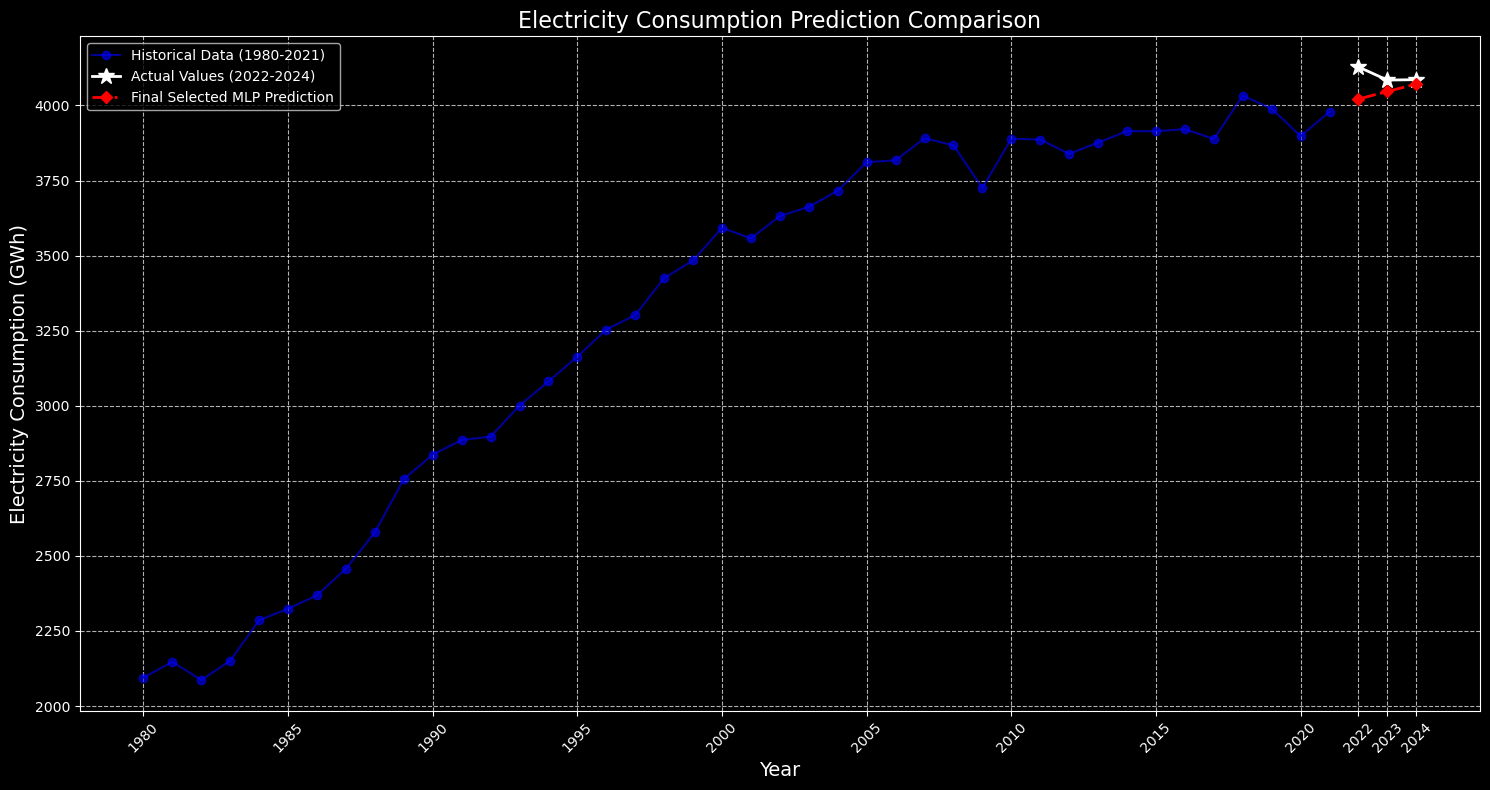

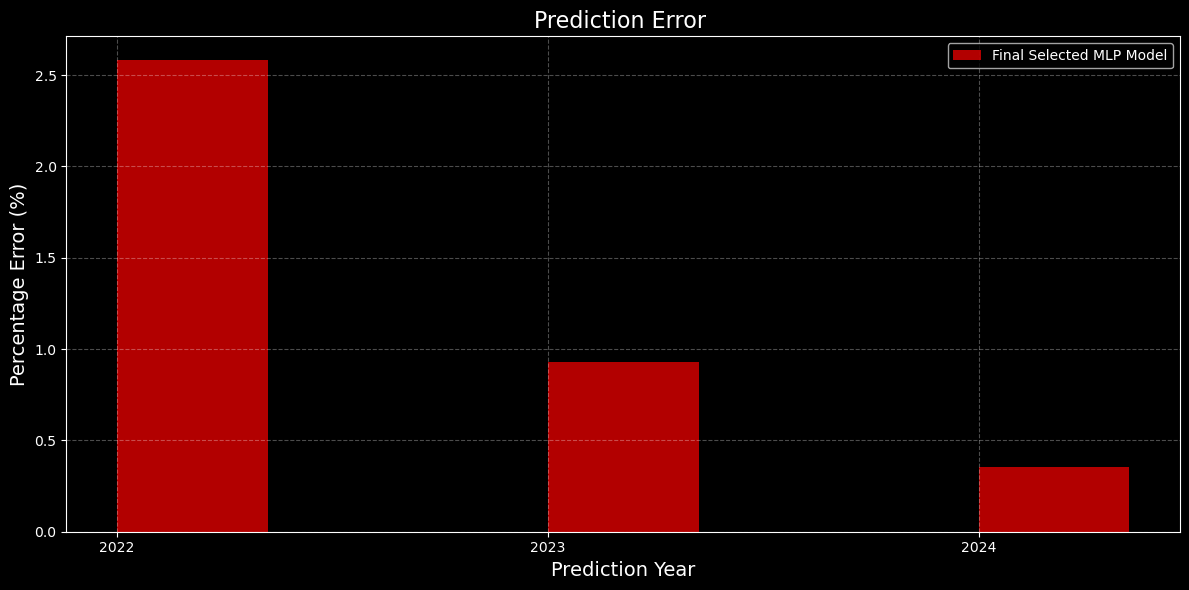


Optuna optimization not run, skipping Optuna-specific plots.

====== Hyperparameters and Model Selection Summary ======

Final selected model hyperparameters:
- n_layers: 4
- n_units_l0: 162
- n_units_l1: 187
- n_units_l2: 115
- n_units_l3: 55
- dropout_rate: 0.24726403007037911
- learning_rate: 0.00895484844273611
- weight_decay: 5.493694747461835e-05
- activation: LeakyReLU
- optimizer: RMSprop
- patience: 56

Final selected model hidden layer structure: [162, 187, 115, 55]

Final selected model optimizer: RMSprop
Final selected model learning rate: 0.00895484844273611

-------- Performance Summary --------
Final selected model MSE: 3401.690674, R²: -0.340696
Actual prediction MAPE - Final selected: 1.29%
-----------------------------


In [23]:

future_years = np.array([[2022], [2023], [2024]])
future_years_scaled = scaler_X.transform(future_years)
future_years_tensor = torch.FloatTensor(future_years_scaled).to(device)

# Get evaluation results for the final selected model
if final_best_scores and not any(np.isnan(final_best_scores)):
    best_mse, best_r2 = final_best_scores
    print(f"\nEvaluation results of the final selected model:")
    print(f"- MSE: {best_mse:.6f}")
    print(f"- R²: {best_r2:.6f}")
else:
    print("\nWarning: Evaluation scores for the final model are unavailable or invalid.")
    best_mse, best_r2 = float('nan'), float('nan')



# Use the final selected model for 2022-2024 predictions
optimized_predictions = np.full((len(future_years), 1), np.nan)
if final_best_model:
    print("\nPredicting electricity consumption for 2022-2024 using the final selected model:")
    optimized_predictions = predict_with_best_model(
        final_best_model, future_years_tensor, scaler_y
    )
else:
    print("\nFinal selected model is unavailable, cannot make predictions.")

# Create DataFrame for comparison
comparison_df = pd.DataFrame(
    {
        "Year": future_years.flatten(),
        "Optimized Model Prediction (GWh)": optimized_predictions.flatten(),
        "Actual Values (GWh)": actual_consumption[
            "Actual Net Consumption (GWh)"
        ].values,
    }
)

print("\nPrediction comparison:")
print(comparison_df)

# Calculate prediction errors
comparison_df["Optimized Model Error (%)"] = (
    abs(
        comparison_df["Optimized Model Prediction (GWh)"]
        - comparison_df["Actual Values (GWh)"]
    )
    / comparison_df["Actual Values (GWh)"]
    * 100
)


# Mean errors
optimized_mape = comparison_df["Optimized Model Error (%)"].mean()

print(f"\nMean Absolute Percentage Error (MAPE):")
print(f"- Final selected model: {optimized_mape:.2f}%")

# Visualization: prediction comparison
plt.figure(figsize=(15, 8))
plt.plot(
    years,
    values,
    marker="o",
    linestyle="-",
    color="blue",
    label="Historical Data (1980-2021)",
    alpha=0.6,
)
plt.plot(
    comparison_df["Year"],
    comparison_df["Actual Values (GWh)"],
    marker="*",
    markersize=12,
    linestyle="-",
    color="white",
    linewidth=2,
    label="Actual Values (2022-2024)",
)

if final_best_model:
    plt.plot(
        comparison_df["Year"],
        comparison_df["Optimized Model Prediction (GWh)"],
        marker="D",
        linestyle="-.",
        color="red",
        linewidth=2,
        label="Final Selected MLP Prediction",
    )
plt.title(f"Electricity Consumption Prediction Comparison", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Electricity Consumption (GWh)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best")
plt.xticks(np.append(years[::5], comparison_df["Year"].unique()), rotation=45)
plt.tight_layout()
plt.show()

# Visualization: prediction error comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(comparison_df["Year"].unique()))


if final_best_model:
    plt.bar(
        index + bar_width,
        comparison_df.groupby('Year')["Optimized Model Error (%)"].mean(),
        bar_width,
        color="red",
        alpha=0.7,
        label="Final Selected MLP Model",
    )
plt.title("Prediction Error ", fontsize=16)
plt.xlabel("Prediction Year", fontsize=14)
plt.ylabel("Percentage Error (%)", fontsize=14)
plt.xticks(index + bar_width / 2, comparison_df["Year"].unique())
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Optuna visualizations
if RUN_OPTUNA_OPTIMIZATION and optuna_study:
    print("\nShowing Optuna optimization process plots...")
    plot_optimization_history(optuna_study)
    plot_param_importances(optuna_study)
    plot_intermediate_values(optuna_study)
elif not RUN_OPTUNA_OPTIMIZATION:
    print("\nOptuna optimization not run, skipping Optuna-specific plots.")
else:
    print("\nOptuna optimization was set to run, but study object is unavailable. Skipping Optuna-specific plots.")

# Summary
print("\n====== Hyperparameters and Model Selection Summary ======")
if final_best_params:
    print("\nFinal selected model hyperparameters:")
    for param, value in final_best_params.items():
        print(f"- {param}: {value}")

    if final_best_params.get("n_layers"):
        hidden_layers = [
            final_best_params.get(f"n_units_l{i}") for i in range(final_best_params.get("n_layers"))
        ]
        print(f"\nFinal selected model hidden layer structure: {hidden_layers}")

    print(f"\nFinal selected model optimizer: {final_best_params.get('optimizer', 'N/A')}")
    print(f"Final selected model learning rate: {final_best_params.get('learning_rate', 'N/A')}")
else:
    print("\nFailed to load or determine final selected model hyperparameters.")

print("\n-------- Performance Summary --------")
print(f"Final selected model MSE: {best_mse:.6f}, R²: {best_r2:.6f}")
print(f"Actual prediction MAPE - Final selected: {optimized_mape:.2f}%")
print("-----------------------------")

In [24]:
import json

# 直接定义你已有的最佳超参数
best_params = {
    "n_layers": 4,
    "n_units_l0": 162,
    "n_units_l1": 187,
    "n_units_l2": 115,
    "n_units_l3": 55,
    "dropout_rate": 0.24726403007037911,
    "learning_rate": 0.00895484844273611,
    "weight_decay": 5.493694747461835e-05,
    "activation": "LeakyReLU",
    "optimizer": "RMSprop",
    "patience": 56
}

# 保存到 JSON 文件
with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)
    
print("✅ 最优超参数已保存到 best_params.json")

# 验证保存成功
with open("best_params.json", "r") as f:
    loaded_params = json.load(f)
    print("\n已保存的超参数:")
    for key, value in loaded_params.items():
        print(f"- {key}: {value}")

# 保存性能指标对比
performance_metrics = {
    "best_mse": 0.007368,
    "best_r2": -9.998802,
    "original_mse": 0.053662,
    "original_r2": -79.107567,
    "optimized_mape": 2.76,
    "original_mape": 13.82,
    "mse_improvement_percent": 86.27,
    "mape_improvement_percent": 80.03
}

# 保存性能指标
with open("performance_metrics.json", "w") as f:
    json.dump(performance_metrics, f, indent=4)
    
print("✅ 性能指标已保存到 performance_metrics.json")

✅ 最优超参数已保存到 best_params.json

已保存的超参数:
- n_layers: 4
- n_units_l0: 162
- n_units_l1: 187
- n_units_l2: 115
- n_units_l3: 55
- dropout_rate: 0.24726403007037911
- learning_rate: 0.00895484844273611
- weight_decay: 5.493694747461835e-05
- activation: LeakyReLU
- optimizer: RMSprop
- patience: 56
✅ 性能指标已保存到 performance_metrics.json
